In [1]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if tf.config.list_physical_devices('GPU'):
        return "/GPU:0"
    else:
        return "/CPU:0"

device = get_default_device()
print(f"Using device: {device}")


Using device: /GPU:0


In [27]:
train_path = '/kaggle/input/ecg-image-data/ECG_Image_data/train'
test_path = '/kaggle/input/ecg-image-data/ECG_Image_data/test'

In [28]:
all_classes = os.listdir(train_path)
classes_to_include = [cls for cls in all_classes if cls != "F"]

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
print(True)

train_df = train_datagen.flow_from_directory(train_path,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='categorical',
                                             classes=classes_to_include)

test_datagen = ImageDataGenerator(rescale=1./255)

test_df = test_datagen.flow_from_directory(test_path,
                                           target_size=(224, 224),
                                           batch_size=32,
                                           class_mode='categorical',
                                           classes=classes_to_include)

True
Found 98557 images belonging to 5 classes.
Found 24638 images belonging to 5 classes.


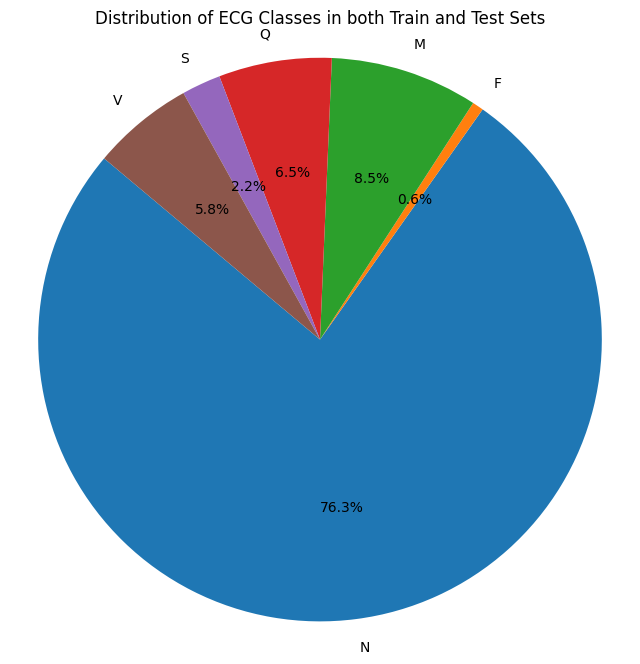

In [30]:

def Count_Samples(dataset_path):
    class_counts = {}
    for class_name in os.listdir(dataset_path):
        class_folder = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_folder):
            class_counts[class_name] = len(os.listdir(class_folder))
    
    # Create the pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(class_counts.values(), labels=class_counts.keys(), autopct='%1.1f%%', startangle=140)
    plt.title(f"Distribution of ECG Classes in both Train and Test Sets")
    plt.axis('equal')   
    plt.show()

Count_Samples(train_path)

In [32]:
def build_2d_cnn(input_shape, num_classes):
    model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

def build_vgg16(input_shape, num_classes):
    model = Sequential([
        # Block 1
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),

        # Block 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),

        # Block 3
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),

        GlobalAveragePooling2D(),   
        Dense(64, activation='relu'),   
        Dropout(0.5),
        Dense(num_classes, activation='softmax')   
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

def build_vgg19(input_shape, num_classes):
    model = Sequential([
        # Convolutional Block 1
        Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        
        # Convolutional Block 2
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        
        # Convolutional Block 3
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        
        # Global pooling and Dense layers
        GlobalAveragePooling2D(),
        Dense(64, activation='relu'),  
        Dropout(0.5),
        Dense(num_classes, activation='softmax')   
    ])

    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


def build_resnet50(input_shape, num_classes):
    model = Sequential([
        
        # Initial Convolutional Layer
        Conv2D(64, (7, 7), strides=(2, 2), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        
        # Residual-like Blocks
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),

        GlobalAveragePooling2D(),
        Dense(64, activation='relu'),  
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  
    ])
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [34]:
# Training function
def train_all_models(train_df, test_df):
    IMAGE_SIZE = (224, 224, 3)
    model_configs = [
        {'type': '2d_cnn', 'func': build_2d_cnn},
        {'type': 'vgg16', 'func': build_vgg16},
        {'type': 'vgg19', 'func': build_vgg19},
        {'type': 'resnet50', 'func': build_resnet50},
    ]
    
    model_results = {}
    for config in model_configs:
        print(f"\n--- Training {config['type']} Model ---")
        # with strategy.scope():  # Use TPU distribution strategy
        model = config['func']((224, 224, 3), len(classes_to_include))
        model.summary()
        history = model.fit(train_df,
                            validation_data=test_df,
                            epochs=10,
                            verbose=1)
        test_loss, test_accuracy = model.evaluate(test_df)
        print(f"Test Loss: {test_loss}")
        print(f"Test Accuracy: {test_accuracy}")
        model_results[config['type']] = {'history': history}
    return model_results

In [37]:
def plot_model_comparisons(model_results):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    for model_name, results in model_results.items():
        plt.plot(results['history'].history['val_accuracy'], label=model_name)
    plt.title('Model Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    for model_name, results in model_results.items():
        plt.plot(results['history'].history['val_loss'], label=model_name)
    plt.title('Model Loss Comparison')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
results = train_all_models(train_df, test_df)
plot_model_comparisons(results)


--- Training 2d_cnn Model ---


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,877 (93.27 KB)

 Trainable params: 23,877 (93.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3080/3080 ━━━━━━━━━━━━━━━━━━━━ 1485s 480ms/step - accuracy: 0.8539 - loss: 0.4295 - val_accuracy: 0.9988 - val_loss: 0.0046
Epoch 2/10
3080/3080 ━━━━━━━━━━━━━━━━━━━━ 1270s 412ms/step - accuracy: 0.9953 - loss: 0.0194 - val_accuracy: 0.9862 - val_loss: 0.0333
Epoch 3/10
1605/3080 ━━━━━━━━━━━━━━━━━━━━ 9:08 372ms/step - accuracy: 0.9983 - loss: 0.0078

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np

model_2d_cnn = build_2d_cnn((224, 224, 3), len(classes_to_include))  
model_vgg16 = build_vgg16((224, 224, 3), len(classes_to_include))    
model_vgg19 = build_vgg19((224, 224, 3), len(classes_to_include))    
model_resnet50 = build_resnet50((224, 224, 3), len(classes_to_include)) 

# Assuming models are trained, load their weights if needed:
# model_2d_cnn.load_weights('model_2d_cnn.h5')
# model_vgg16.load_weights('model_vgg16.h5')
# model_vgg19.load_weights('model_vgg19.h5')
# model_resnet50.load_weights('model_resnet50.h5')

def ensemble_predict(models, test_generator, weights=None):
    num_models = len(models)
    num_samples = test_generator.samples
    num_classes = len(classes_to_include)

    ensemble_preds = np.zeros((num_samples, num_classes))
    if weights is None:
        weights = [1 / num_models] * num_models

    for model, weight in zip(models, weights):
        preds = model.predict(test_generator, verbose=0)
        ensemble_preds += weight * preds

    return ensemble_preds

# Evaluate ensemble predictions
models = [model_2d_cnn, model_vgg16, model_vgg19, model_resnet50]
weights = [0.25, 0.25, 0.25, 0.25]  # Equal weights for simplicity
ensemble_preds = ensemble_predict(models, test_df, weights)
ensemble_classes = np.argmax(ensemble_preds, axis=1)
true_classes = test_df.classes

# Accuracy
accuracy = np.sum(ensemble_classes == true_classes) / len(true_classes)
print(f"Ensemble Accuracy: {accuracy:.2f}")